# Importation des bibliothèques nécessaires

In [13]:
import json
import pickle
import pandas as pd
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import sent_tokenize

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

import warnings
warnings.filterwarnings('ignore')

In [14]:
words = []
classes = []
documents = []
ignore_words = ['?', '!']

# Importation des données

In [15]:
data_file = open('intents.json').read()
intents = json.loads(data_file)

In [16]:
dic = {"tag":[], "patterns":[], "responses":[]}
for example in intents['intents']:
    for pattern in example['patterns']:
        dic['patterns'].append(pattern)
        dic['tag'].append(example['tag'])
        dic['responses'].append(example['responses'])
df = pd.DataFrame.from_dict(dic)
df

,tag,patterns,responses
0,tarhib,salam,"[fin!, labass!, bach nkder neawnek]"
1,tarhib,cv,"[fin!, labass!, bach nkder neawnek]"
2,tarhib,ach ka t3awd,"[fin!, labass!, bach nkder neawnek]"
3,tarhib,fin,"[fin!, labass!, bach nkder neawnek]"
4,tarhib,nharek mbrok,"[fin!, labass!, bach nkder neawnek]"
...,...,...,...
70,nokat,nokta,[hada wa7ed lme3gaz wa7ed nhar mrato ka tdo9 l...
71,nokat,9ol liya nokta,[hada wa7ed lme3gaz wa7ed nhar mrato ka tdo9 l...
72,nokat,bghit nokta,[hada wa7ed lme3gaz wa7ed nhar mrato ka tdo9 l...
73,nokat,nokat,[hada wa7ed lme3gaz wa7ed nhar mrato ka tdo9 l...


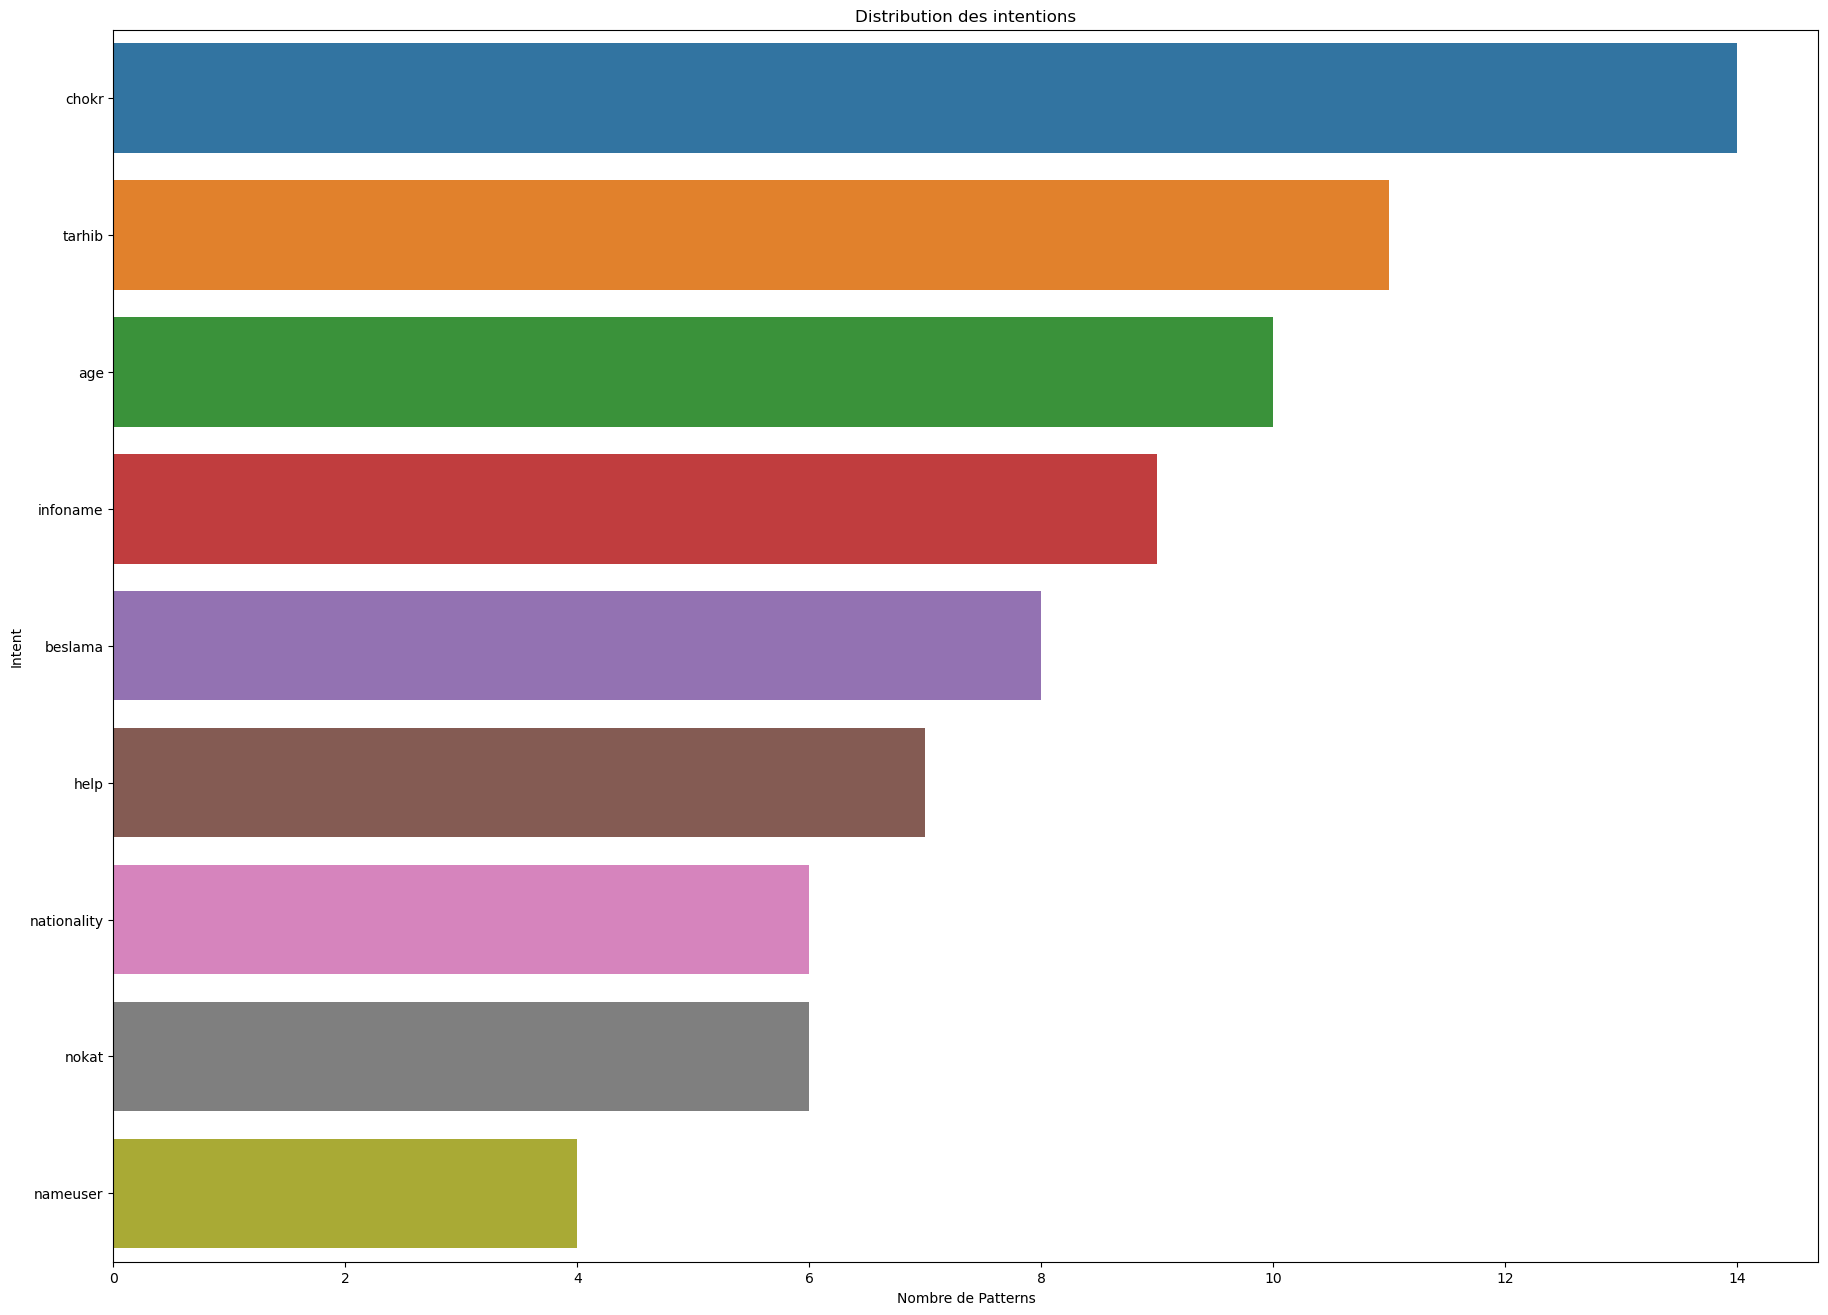

In [17]:
plt.figure(figsize=(22, 16))
sns.countplot(y='tag', data=df, order=df['tag'].value_counts().index)
plt.title('Distribution des intentions')
plt.xlabel('Nombre de Patterns')
plt.ylabel('Intent')
plt.show()

## Prétraitement

In [18]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        documents.append((w, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

### mets en minuscules chaque mot, puis supprime les doublons.

In [19]:
words = [w.lower() for w in words if w not in ignore_words]
words = sorted(list(set(words)))

In [20]:
# Trier classes
classes = sorted(list(set(classes)))

In [21]:
# documents = combinaison entre motifs et intentions
print(len(documents), "documents")
# classes = intents
print(len(classes), "classes")
# words = tous les mots, vocabulaire
print(len(words), "words")

75 documents
9 classes
99 words


### Enregistrer les deux tableaux pour les utiliser plus tard pour la prédiction.

In [22]:
pickle.dump(words, open('texts.pkl', 'wb'))
pickle.dump(classes, open('labels.pkl', 'wb'))

### Créer notre data d'entrainement

In [23]:
training = []

In [24]:
output_empty = [0] * len(classes)

In [25]:
for doc in documents:
    bag = []
    pattern_words = doc[0]
    pattern_words = [word.lower() for word in pattern_words]
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

In [26]:
random.shuffle(training)

In [27]:
train_x = [inner_list[0] for inner_list in training]
train_y = [inner_list[1] for inner_list in training]

## Créer notre modele de deep learning

In [17]:
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

In [24]:
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,641 (84.54 KB)

 Trainable params: 21,641 (84.54 KB)

 Non-trainable params: 0 (0.00 B)

## Ajuster et enregistrer le modèle.

In [25]:
hist = model.fit(np.array(train_x), np.array(train_y), epochs=100, batch_size=5, verbose=1)
model.save('model.h5', hist)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6694 - loss: 1.2919  
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4818 - loss: 1.2445 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6781 - loss: 1.1292 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7516 - loss: 0.9614 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.6891 - loss: 0.9447
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7430 - loss: 0.8239 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7957 - loss: 0.7645 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.7331 - loss: 0.7025
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8318 - loss: 0.6548 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8386 - loss: 0.6258 
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8394 - loss: 0.5263 
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

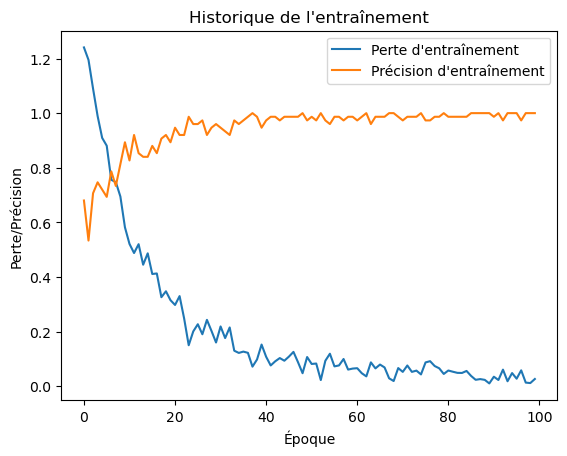

In [26]:
plt.plot(hist.history['loss'], label='Perte d\'entraînement')
plt.plot(hist.history['accuracy'], label='Précision d\'entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte/Précision')
plt.title('Historique de l\'entraînement')
plt.legend()
plt.show()

# Test : Application Web

In [28]:
model = load_model('model.h5')

In [29]:
intents = json.loads(open('intents.json').read())
words = pickle.load(open('texts.pkl', 'rb'))
classes = pickle.load(open('labels.pkl', 'rb'))

In [30]:
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [word.lower() for word in sentence_words]
    return sentence_words

In [31]:
def bow(sentence, words, show_details=True):
    sentence_words = clean_up_sentence(sentence)
    bag = [0] * len(words)
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                bag[i] = 1
                if show_details:
                    print("found in bag: %s" % w)
    return (np.array(bag))

In [32]:
def predict_class(sentence, model):
    p = bow(sentence, words, show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

In [33]:
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if (i['tag'] == tag):
            responses = i['responses']
            response = random.choice(responses)
            sentences = sent_tokenize(response)
            sentence = random.choice(sentences)
            break
    return sentence

In [34]:
def chatbot_response(msg):
    ints = predict_class(msg, model)
    res = getResponse(ints, intents)
    return res

In [ ]:
from flask import Flask, jsonify, render_template, request
app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route("/get")
def response():
    query = request.args.get('msg')
    res = chatbot_response(query)
    return jsonify({"response": res})

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.72.177.143:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:10.72.177.143 - - [22/May/2024 14:52:08] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


INFO:werkzeug:10.72.177.143 - - [22/May/2024 14:52:17] "GET /get?msg=salam HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


INFO:werkzeug:10.72.177.143 - - [22/May/2024 14:52:30] "GET /get?msg=chkon%20nta HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


INFO:werkzeug:10.72.177.143 - - [22/May/2024 14:52:38] "GET /get?msg=nokta HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


INFO:werkzeug:10.72.177.143 - - [22/May/2024 14:52:56] "GET /get?msg=chokran HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


INFO:werkzeug:10.72.177.143 - - [22/May/2024 14:53:03] "GET /get?msg=bslama HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


INFO:werkzeug:10.72.177.143 - - [22/May/2024 14:53:55] "GET /get?msg=chi%20nokta%20khra HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


INFO:werkzeug:10.72.177.143 - - [22/May/2024 14:54:27] "GET /get?msg=ch7al%20f3mrek HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


INFO:werkzeug:10.72.177.143 - - [22/May/2024 14:56:13] "GET /get?msg=chno%20smytk HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


INFO:werkzeug:10.72.177.143 - - [22/May/2024 14:56:24] "GET /get?msg=ana%20smyti%20Khalid HTTP/1.1" 200 -
